##Dataset processing and import

In [ ]:
%%capture
!pip install datasets>=2.18.0 transformers>=4.38.2 sentence-transformers>=2.5.1 setfit>=1.0.3 accelerate>=0.27.2 seqeval>=1.2.2

In [ ]:
!pip install scikit-learn matplotlib scipy evaluate

In [ ]:
from datasets import load_dataset
from tqdm import tqdm

# Load dataset from CSV using datasets library with encoding specified
dataset = load_dataset("csv", data_files="/content/super_sms_dataset.csv", encoding="latin-1")

# Correct the preprocessing function and apply with batched=True
def preprocess_function(examples):
    # Process labels correctly by checking each string in 'v1'
    examples["label"] = [1 if lbl == "spam" else 0 for lbl in examples["Labels"]]
    return examples

# Apply preprocessing to the dataset with batched=True
dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/67010 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['SMSes', 'Labels', 'label'],
        num_rows: 67010
    })
})

In [ ]:
# Split dataset
train_data = dataset["train"].train_test_split(test_size=0.2, seed=42)["train"]
test_data = dataset["train"].train_test_split(test_size=0.2, seed=42)["test"]

##BERT-Model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

#Load model and tokenizer
model_id = "bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(
    model_id, num_labels=2
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
train_data

Dataset({
    features: ['SMSes', 'Labels', 'label'],
    num_rows: 53608
})

In [ ]:
from transformers import DataCollatorWithPadding

# Ensure the tokenizer is properly initialized
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def preprocess_function(examples):
    """Tokenize input data"""
    # Ensure SMSes is a list of strings
    texts = examples["SMSes"]
    if isinstance(texts, str):  # If it's a single string, convert to list
        texts = [texts]
    elif isinstance(texts, list):  # If it's a list, ensure all elements are strings
        texts = [str(text) for text in texts]
    else:
        raise ValueError(f"Unexpected input type: {type(texts)}")

    return tokenizer(texts, truncation=True, padding="max_length", max_length=512)

# Apply tokenization while removing old columns
tokenized_train = train_data.map(preprocess_function, batched=True, remove_columns=["SMSes", "Labels"])
tokenized_test = test_data.map(preprocess_function, batched=True, remove_columns=["SMSes", "Labels"])

Map:   0%|          | 0/53608 [00:00<?, ? examples/s]

Map:   0%|          | 0/13402 [00:00<?, ? examples/s]

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import softmax
from sklearn.metrics import (accuracy_score, precision_score,
                            recall_score, f1_score,
                            roc_curve, auc, roc_auc_score)  # Added roc_auc_score

def compute_metrics(eval_pred):
    """Compute evaluation metrics with safe handling for division by zero."""
    logits, labels = eval_pred

    # Get predictions and probabilities
    predictions = np.argmax(logits, axis=1)
    probs = softmax(logits, axis=1)[:, 1]  # Class 1 probabilities (spam)

    # Compute AUC only if there are both classes present
    if len(np.unique(labels)) < 2:
        auc_value = float("nan")
    else:
        auc_value = roc_auc_score(labels, probs)

    return {
        "accuracy": accuracy_score(labels, predictions),
        "precision": precision_score(labels, predictions, average='binary', zero_division=0),
        "recall": recall_score(labels, predictions, average='binary', zero_division=0),
        "f1": f1_score(labels, predictions, average='binary', zero_division=0),
        "auc": auc_value,
    }

# For ROC curve generation (run this separately after evaluation)
def plot_roc_curve(labels, probs):
    fpr, tpr, thresholds = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)  # This uses the auc function from sklearn

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    plt.close()

In [ ]:
from transformers import TrainingArguments, Trainer

# Training arguments for parameter tuning
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=1,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)

# Trainer which executes the training process
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   #compute_metrics=compute_metrics,
)

<ipython-input-14-8f6c5e3dde62>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Step,Training Loss
500,0.007600
1000,0.000000
1500,0.000000
2000,0.000000
2500,0.000000
3000,0.000000


TrainOutput(global_step=3351, training_loss=0.0011398727044736078, metrics={'train_runtime': 4724.2086, 'train_samples_per_second': 11.348, 'train_steps_per_second': 0.709, 'total_flos': 1.410485745573888e+16, 'train_loss': 0.0011398727044736078, 'epoch': 1.0})

In [ ]:
tokenized_test

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 13402
})

In [ ]:
import numpy as np

def evaluate_model(trainer, test_dataset, test_labels, model_name):
    predictions = trainer.predict(test_dataset)
    pred_labels = np.argmax(predictions.predictions, axis=-1)

    accuracy = accuracy_score(test_labels, pred_labels)
    f1 = f1_score(test_labels, pred_labels, average='weighted')
    precision = precision_score(test_labels, pred_labels, average='weighted')
    recall = recall_score(test_labels, pred_labels, average='weighted')
    roc_auc = roc_auc_score(test_labels, pred_labels, multi_class='ovr')

    print(f"{model_name} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, ROC AUC: {roc_auc:.4f}")

# Prepare dataset for evaluation
test_dataset = tokenized_test.remove_columns(["label"])
test_labels = tokenized_test["label"]

# Evaluate model
evaluate_model(trainer, test_dataset, test_labels, model_id)

bert-base-cased - Accuracy: 1.0000, F1 Score: 1.0000, Precision: 1.0000, Recall: 1.0000, ROC AUC: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [ ]:
import pandas as pd

# Convert Dataset to DataFrame
test_df = pd.DataFrame(test_data)

# Extract test dataset (features) and labels
test_dataset = test_df['SMSes'].tolist()  # List of SMS texts
test_labels = test_df['label'].tolist()  # Labels as a list

# Evaluate model
evaluate_model(trainer, tokenized_test, test_labels, model_id)

In [ ]:
import matplotlib.pyplot as plt
plot_roc_curve(results.label_ids, probs)
plt.imshow(plt.imread('roc_curve.png'))
plt.show()

##MobileBERT Model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

#Load model and tokenizer
model_id = "google/mobilebert-uncased"
model = AutoModelForSequenceClassification.from_pretrained(
    model_id, num_labels=2
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import DataCollatorWithPadding

# Pad to the longest sequence in the batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def preprocess_function(examples):
   """Tokenize input data"""
   return tokenizer(examples["v2"], truncation=True)

# Tokenize train/test data
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_test = test_data.map(preprocess_function, batched=True)

In [ ]:
from transformers import TrainingArguments, Trainer

# Training arguments for parameter tuning
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)

# Trainer which executes the training process
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

<ipython-input-89-4bc2e37cb2bb>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Step,Training Loss
500,7754.083000


TrainOutput(global_step=837, training_loss=5001.575418160096, metrics={'train_runtime': 171.179, 'train_samples_per_second': 78.111, 'train_steps_per_second': 4.89, 'total_flos': 103850944678440.0, 'train_loss': 5001.575418160096, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 458.7601013183594,
 'eval_accuracy': 0.9847533632286996,
 'eval_precision': 0.9571428571428572,
 'eval_recall': 0.9241379310344827,
 'eval_f1': 0.9403508771929825,
 'eval_auc': 0.9624031283327408,
 'eval_runtime': 3.2867,
 'eval_samples_per_second': 339.244,
 'eval_steps_per_second': 21.298,
 'epoch': 3.0}

In [ ]:
results = trainer.predict(tokenized_test)

# Generate ROC curve
probs = softmax(results.predictions, axis=1)[:, 1]

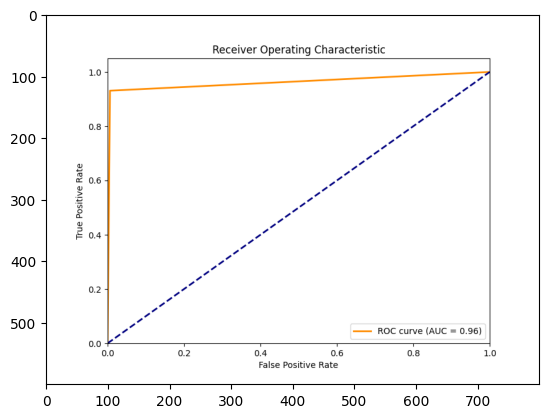

In [ ]:
import matplotlib.pyplot as plt
plot_roc_curve(results.label_ids, probs)
plt.imshow(plt.imread('roc_curve.png'))
plt.show()

##TinyBERT

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

#Load model and tokenizer
model_id = "huawei-noah/TinyBERT_General_4L_312D"
model = AutoModelForSequenceClassification.from_pretrained(
    model_id, num_labels=2
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import DataCollatorWithPadding

# Pad to the longest sequence in the batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def preprocess_function(examples):
   """Tokenize input data"""
   return tokenizer(examples["v2"], truncation=True)

# Tokenize train/test data
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_test = test_data.map(preprocess_function, batched=True)

In [ ]:
from transformers import TrainingArguments, Trainer

# Training arguments for parameter tuning
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)

# Trainer which executes the training process
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

<ipython-input-96-4bc2e37cb2bb>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Step,Training Loss
500,0.141000


TrainOutput(global_step=837, training_loss=0.10568800621989807, metrics={'train_runtime': 22.9966, 'train_samples_per_second': 581.434, 'train_steps_per_second': 36.397, 'total_flos': 23746666016136.0, 'train_loss': 0.10568800621989807, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.0565374456346035,
 'eval_accuracy': 0.9874439461883409,
 'eval_precision': 0.9712230215827338,
 'eval_recall': 0.9310344827586207,
 'eval_f1': 0.9507042253521126,
 'eval_auc': 0.995755421258443,
 'eval_runtime': 0.5401,
 'eval_samples_per_second': 2064.463,
 'eval_steps_per_second': 129.608,
 'epoch': 3.0}

In [ ]:
results = trainer.predict(tokenized_test)

# Generate ROC curve
probs = softmax(results.predictions, axis=1)[:, 1]

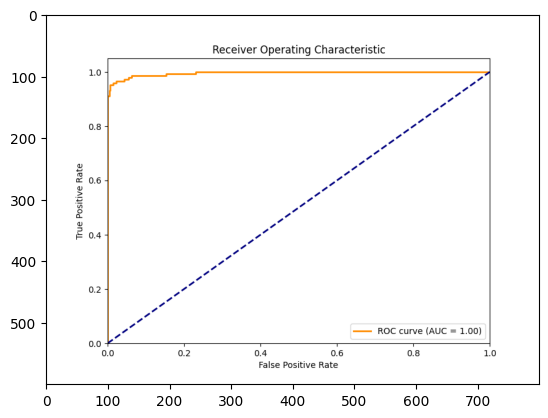

In [ ]:
import matplotlib.pyplot as plt
plot_roc_curve(results.label_ids, probs)
plt.imshow(plt.imread('roc_curve.png'))
plt.show()

##Model Size Evaluation

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

def calculate_model_size(model):
    """Calculate model size in MB without loading into GPU"""
    with torch.no_grad():
        param_size = 0
        for param in model.parameters():
            param_size += param.nelement() * param.element_size()
        buffer_size = 0
        for buffer in model.buffers():
            buffer_size += buffer.nelement() * buffer.element_size()
        size_all_mb = (param_size + buffer_size) / (1024 ** 2)
    return size_all_mb

# List of models to evaluate
models_to_compare = [
    ("google/mobilebert-uncased", "MobileBERT"),
    ("huawei-noah/TinyBERT_General_4L_312D", "TinyBERT"),
    ("bert-base-cased", "Original BERT")  # For comparison
]

# Calculate and print model sizes
print("\nModel Size Comparison:")
for model_id, model_name in models_to_compare:
    # Load model in CPU mode
    model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
    tokenizer = AutoTokenizer.from_pretrained(model_id)

    # Calculate size
    model_size = calculate_model_size(model)
    param_count = sum(p.numel() for p in model.parameters())

    print(f"\n{model_name}:")
    print(f"- Parameters: {param_count:,}")
    print(f"-Memory Size: {model_size:.2f} MB")
    print(f"- Tokenizer Vocab Size: {tokenizer.vocab_size:,}")

# Then proceed with training code from previous answer


Model Size Comparison:


Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



MobileBERT:
- Parameters: 24,582,914
-Memory Size: 93.78 MB
- Tokenizer Vocab Size: 30,522


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



TinyBERT:
- Parameters: 14,350,874
-Memory Size: 54.75 MB
- Tokenizer Vocab Size: 30,522

Original BERT:
- Parameters: 108,311,810
-Memory Size: 413.18 MB
- Tokenizer Vocab Size: 28,996
